In [397]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize, LogNorm, ListedColormap
import hydroeval as he
import h5py
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

sys.path.append('../')
sys.path.append('../pywrdrb/')

from pywrdrb.post.get_results import get_pywr_results, get_base_results

from pywrdrb.pywr_drb_node_data import upstream_nodes_dict

# Custom modules

from pywrdrb.utils.constants import cms_to_mgd, cm_to_mg, cfs_to_mgd
from pywrdrb.utils.lists import reservoir_list, majorflow_list, reservoir_link_pairs, reservoir_list_nyc, majorflow_list
from pywrdrb.utils.directories import input_dir, fig_dir, output_dir, model_data_dir
from pywrdrb.utils.hdf5 import get_hdf5_realization_numbers

from pywrdrb.plotting.styles import base_model_colors, model_hatch_styles, paired_model_colors, scatter_model_markers
import pywrdrb.plotting



In [307]:
## Load observed data

lower_elevations= pd.read_csv(f'{input_dir}historic_reservoir_ops/lower_basin_reservoir_elevation.csv', 
                            index_col=0, parse_dates=True)

storage_curves = {}
for res in ['blueMarsh', 'beltzvilleCombined', 'fewalter']:
    storage_curves[res]= pd.read_csv(f'{input_dir}historic_reservoir_ops/{res}_elevation_storage_curve.csv', sep=',')

### get reservoir storage capacities
istarf = pd.read_csv(f'{model_data_dir}drb_model_istarf_conus.csv')
def get_reservoir_capacity(reservoir):
    return float(istarf['Adjusted_CAP_MG'].loc[istarf['reservoir'] == reservoir].iloc[0])
capacities = {r: get_reservoir_capacity(r) for r in reservoir_list_nyc}
capacities['combined'] = sum([capacities[r] for r in reservoir_list_nyc])

nyc_hist_storage = pd.read_csv(f'{input_dir}/historic_NYC/NYC_storage_daily_2000-2021.csv', sep=',', index_col=0, parse_dates=True)
nyc_hist_storage.index = pd.to_datetime(nyc_hist_storage.index)


In [483]:
## Load data    
start_date = '2017-10-01'
end_date = '2022-12-31'
n_realizations=30

# Load Pywr-DRB simulation models
if end_date > '2016-12-31':
    pywr_models= ['obs_pub_nwmv21_NYCScaled','obs_pub_nhmv10_NYCScaled_modified_starfit',
                'obs_pub_nwmv21_NYCScaled_ensemble','obs_pub_nhmv10_NYCScaled_ensemble']

    base_models = ['obs', 'obs_pub_nhmv10_NYCScaled','obs_pub_nwmv21_NYCScaled']

else:
    pywr_models= ['nhmv10', 'nwmv21',
                  'obs_pub_nhmv10_NYCScaled_modified_starfit', 
                  'obs_pub_nwmv21_NYCScaled',
                'obs_pub_nwmv21_NYCScaled_ensemble','obs_pub_nhmv10_NYCScaled_ensemble']

    base_models = ['obs', 'obs_pub_nhmv10_NYCScaled','obs_pub_nwmv21_NYCScaled', 'nhmv10', 'nwmv21']

# Test single ensemble
pywr_models= ['obs_pub_nhmv10_NYCScaled', 'obs_pub_nhmv10_NYCScaled_ensemble']
base_models = ['obs']


reservoir_downstream_gages = {}
major_flows = {}
storages={}
inflows={}
datetime_index = pd.date_range(start=start_date, end=end_date, freq='D')

for model in pywr_models:
    print(model)
    if 'ensemble' in model:
        n_realizations = 30 
    else:
        n_realizations = 1
    reservoir_downstream_gages[f'pywr_{model}'] = {}
    major_flows[f'pywr_{model}'] = {}
    storages[f'pywr_{model}']={}

    for i in range(n_realizations):
        reservoir_downstream_gages[f'pywr_{model}'][f'realization_{i}'], datetime_index = get_pywr_results(output_dir, model, 'reservoir_downstream_gage', datetime_index=datetime_index, scenario=i)
        reservoir_downstream_gages[f'pywr_{model}'][f'realization_{i}'] = reservoir_downstream_gages[f'pywr_{model}'][f'realization_{i}'].loc[start_date:end_date,:]
        
        major_flows[f'pywr_{model}'][f'realization_{i}'], datetime_index = get_pywr_results(output_dir, model, 'major_flow', datetime_index=datetime_index, scenario=i)
        major_flows[f'pywr_{model}'][f'realization_{i}'] = major_flows[f'pywr_{model}'][f'realization_{i}'].loc[start_date:end_date,:]
        
        storages[f'pywr_{model}'][f'realization_{i}'], datetime_index = get_pywr_results(output_dir, model, 'res_storage', datetime_index=datetime_index, scenario=i)
        storages[f'pywr_{model}'][f'realization_{i}'] = storages[f'pywr_{model}'][f'realization_{i}'].loc[start_date:end_date,:]
        
    # else:
    #     reservoir_downstream_gages[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'reservoir_downstream_gage', datetime_index=datetime_index)
    #     reservoir_downstream_gages[f'pywr_{model}'] = reservoir_downstream_gages[f'pywr_{model}'].loc[start_date:end_date,:]
        
    #     major_flows[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'major_flow', datetime_index=datetime_index)
    #     major_flows[f'pywr_{model}'] = major_flows[f'pywr_{model}'].loc[start_date:end_date,:]
    #     inflows[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'inflow', datetime_index=datetime_index)

    #     storages[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'res_storage', datetime_index=datetime_index)
pywr_models = [f'pywr_{m}' for m in pywr_models]



obs_pub_nhmv10_NYCScaled
obs_pub_nhmv10_NYCScaled_ensemble


In [484]:
base_models = ['obs', 'obs_pub_nhmv10_NYCScaled']
# Load base (non-pywr) models
# datetime_index = list(reservoir_downstream_gages.values())[0].index
for model in base_models:
    print(model)
    if model == 'obs':
        reservoir_downstream_gages[model], datetime_index = get_base_results(input_dir, model, datetime_index, 'reservoir_downstream_gage')
        reservoir_downstream_gages[model] = reservoir_downstream_gages[model].loc[start_date:end_date, :]

        major_flows[model], datetime_index = get_base_results(input_dir, model, datetime_index, 'major_flow')
        major_flows[model] = major_flows[model].loc[start_date:end_date, :]
    else:
        reservoir_downstream_gages[model] = {}
        major_flows[model] = {}
        reservoir_downstream_gages[model]['realization_0'], datetime_index = get_base_results(input_dir, model, datetime_index, 'reservoir_downstream_gage')
        reservoir_downstream_gages[model]['realization_0'] = reservoir_downstream_gages[model]['realization_0'].loc[start_date:end_date, :]

        major_flows[model]['realization_0'], datetime_index = get_base_results(input_dir, model, datetime_index, 'major_flow')
        major_flows[model]['realization_0'] = major_flows[model]['realization_0'].loc[start_date:end_date, :]

obs
obs_pub_nhmv10_NYCScaled


In [359]:
    
def get_ensemble_error_metrics(ensemble_results, observed_results, model, node):
    """
    Generate error metrics (NSE, KGE, correlation, bias, etc.) for 
    each realization in an ensemble at a specific node for specific model.

    Args:
        ensemble_results (dict): A dictionary containing dataframes of results.
        observed_results (pandas.DataFrame): A dataframe containing observed flow data.
        models (list): A list of model names (str) to compute error metrics for.
        nodes (list): A list of node names (str) to compute error metrics for.

    Returns:
        pd.DataFrame: A dataframe containing error metrics for the specified models and nodes.
    """
    # assert('ensemble' in model), 'The model dataset must be an ensemble, with "ensemble" in the name'
    assert('realization_' in list(ensemble_results.keys())[0]), 'ensemble_results[model] must be a dict of Dfs with keys of the form "realization_#"'
    
    ensemble_results_metrics = {}
    
    ### compile error across models/nodes/ensemble/metrics
    for i, real in enumerate(list(ensemble_results.keys())):

        obs = observed_results[node]
        modeled = ensemble_results[real][node]

        ### only do models with nonzero entries (eg remove some weap)
        if np.sum(modeled) > 0:
            ### get kge & nse
            kge, r, alpha, beta = he.evaluator(he.kge, modeled, obs)
            nse = he.evaluator(he.nse, modeled, obs)
            logkge, logr, logalpha, logbeta = he.evaluator(he.kge, modeled, obs, transform='log')
            lognse = he.evaluator(he.nse, modeled, obs, transform='log')

            ### get Kolmogorov-Smirnov Statistic, & metric is 1 minus this (1 in ideal case, 0 in worst case)
            kss, _ = stats.ks_2samp(modeled, obs)
            kss = 1 - kss

            resultsdict = {'nse': nse[0], 'kge': kge[0], 'r': r[0], 'alpha': alpha[0], 'beta': beta[0],
                        'lognse': lognse[0], 'logkge': logkge[0], 'logr': logr[0], 'logalpha': logalpha[0],
                        'logbeta': logbeta[0], 'kss': kss}

            resultsdict['node'] = node
            resultsdict['realization'] = int(real.split('_')[-1])
            
            if i == 0:
                ensemble_results_metrics = pd.DataFrame(resultsdict, index=[0])
            else:
                ensemble_results_metrics = pd.concat([ensemble_results_metrics, pd.DataFrame(resultsdict, index=[0])])
                
        # Set the 'realization' column as the index and remove old
    ensemble_results_metrics.set_index('realization', inplace=True)
                
    return ensemble_results_metrics

In [488]:
def get_ensemble_RRV_metrics(ensemble_results, observed_results, node):
    """
    Calculate measures of reliability, resilience, and vulnerability based on Hashimoto et al. (1982) WRR.

    Args:
        results (dict): Dictionary containing model results for different nodes.
        models (list): List of model names (str) to include in the analysis.
        nodes (list): List of node names (str) to include in the analysis.

    Returns:
        pd.DataFrame: DataFrame containing reliability, resiliency, and vulnerability metrics for each model and node.
    """
    thresholds = {'delMontague': 1131.05, 'delTrenton': 1938.950669}  ### FFMP flow targets (MGD)
    eps = 1e-9
    thresholds = {k: v - eps for k, v in thresholds.items()}
    
    assert('realization_' in list(ensemble_results.keys())[0]), 'ensemble_results[model] must be a dict of Dfs with keys of the form "realization_#"'
    
    ### compile error across models/nodes/ensemble/metrics
    for i, real in enumerate(list(ensemble_results.keys())):

        obs = observed_results[node]
        modeled = ensemble_results[real][node]

        ### only do models with nonzero entries (eg remove some weap)
        if np.sum(modeled) > 0:
            ### reliability is the fraction of time steps above threshold
            reliability = (modeled > thresholds[node]).mean()
            ### resiliency is the probability of recovering to above threshold if currently under threshold
            if reliability < 1 - eps:
                resiliency = np.logical_and((modeled.iloc[:-1] < thresholds[node]).reset_index(drop=True), \
                                            (modeled.iloc[1:] >= thresholds[node]).reset_index(drop=True)).mean() / \
                                (1 - reliability)
            else:
                resiliency = np.nan
            ### vulnerability is the expected maximum severity of a failure event
            if reliability > eps:
                max_shortfalls = []
                max_shortfall = 0
                in_event = False
                for i in range(len(modeled)):
                    v = modeled.iloc[i]
                    if v < thresholds[node]:
                        in_event = True
                        s = thresholds[node] - v
                        max_shortfall = max(max_shortfall, s)
                    else:
                        if in_event:
                            max_shortfalls.append(max_shortfall)
                            in_event = False
                vulnerability = np.mean(max_shortfalls)
            else:
                vulnerability = np.nan
            
            resultsdict = {'reliability': reliability, 'resiliency': resiliency, 'vulnerability': vulnerability}
            resultsdict['node'] = node
            resultsdict['realization'] = int(real.split('_')[-1])

            try:
                ensemble_results_metrics = pd.concat([ensemble_results_metrics, pd.DataFrame(resultsdict, index=[0])])
            except:
                ensemble_results_metrics = pd.DataFrame(resultsdict, index=[0])

    # Set the 'realization' column as the index and remove old
    ensemble_results_metrics.set_index('realization', inplace=True)
    return ensemble_results_metrics


ensemble_rrv = get_ensemble_RRV_metrics(major_flows['pywr_obs_pub_nhmv10_NYCScaled_ensemble'], major_flows['obs'], 
                         'delTrenton')

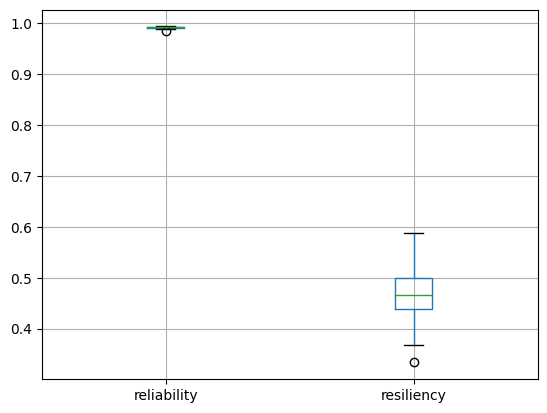

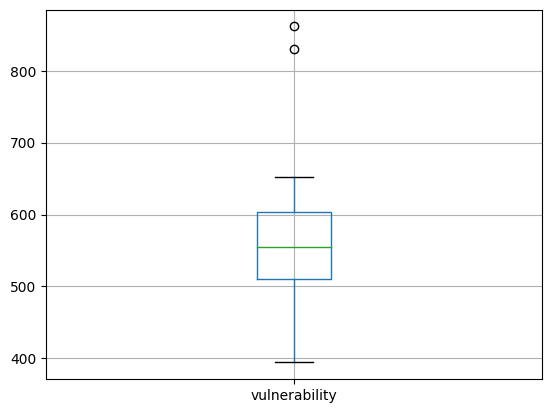

In [491]:
fig, ax = plt.subplots()
ensemble_rrv.boxplot(column = ['reliability', 'resiliency'], ax=ax)
plt.show()

fig, ax = plt.subplots()
ensemble_rrv.boxplot(column = ['vulnerability'], ax=ax)
plt.show()

In [478]:
ensemble_rrv.columns

Index(['reliability', 'resiliency', 'vulnerability', 'node'], dtype='object')

In [464]:
def make_polar_plot(error_metrics, models, node,
                    metric_names, ideal_score, filename, sub_title,
                    metric_mins,
                    colordict = base_model_colors,
                    r_max = 1.5,
                    inner_r = 0.5,
                    normalize = False,
                    use_cmap = True,
                    cmap = 'rainbow',
                    color_by = 0,
                    scale_ideal = False,
                    plot_spokes = True,
                    buffer = 0.0,
                    cut_negatives = True,
                    show_legend = True,
                    figsize = (6,6),
                    save_fig=False,
                    line_width = 1,
                    line_alpha = 0.1):

    # Checks
    #assert(len(ideal_score) == len(metric_names)), 'Length of ideal scores != number of metric names.'
    
    _, n_metrics = error_metrics[models[0]].shape
    n_spokes = n_metrics if use_cmap else n_metrics + 1
    if use_cmap:
        theta =  np.linspace(0, 2*np.pi, n_spokes)
    else:
        theta =  np.linspace(0, 2*np.pi, n_spokes)
        
    def get_radial_data(data, refit_scaler = True, scale_model = None,
                        use_cmap = use_cmap):
        data = data.copy()
        assert(data.shape[1] == len(metric_names)), 'Number of data columns != number of metric names.'

        # Find the minimum and maximum achieved objective values
        data_mins = data.min(axis = 0)
        data_maxs = data.max(axis = 0)

        # Create a normalized data set
        if refit_scaler:
            scaler = MinMaxScaler()
            scale_model = scaler.fit(np.vstack((data, metric_mins)))
            
        norm_data = scale_model.transform(data)
        norm_ideal = scale_model.transform(ideal_score.reshape(1, -1))
        norm_ideal = norm_ideal.flatten()

        # Remove color_by and add the 1st metric to end
        if use_cmap:
            stacked_norm_data = np.hstack((np.delete(norm_data, color_by, axis = 1), np.delete(norm_data, color_by, axis = 1)[:,0:1]))
            stacked_data = np.hstack((np.delete(data, color_by, axis = 1), np.delete(data, color_by, axis = 1)[:,0:1]))
            ideal = np.hstack((np.delete(norm_ideal, color_by, axis = 1), np.delete(norm_ideal, color_by, axis = 1)[:,0:1]))
            ideal = ideal[0,:].flatten()
        else:
            stacked_norm_data = np.hstack((norm_data, norm_data[:,0:1]))
            stacked_data = np.hstack((data, data[:,0:1]))
            ideal = np.hstack((norm_ideal, norm_ideal[0:1]))


        # Define the radial data - scaled according to norms
        r_data = np.zeros_like(stacked_norm_data)

        if scale_ideal:
            shift_ideal = np.ones(n_spokes) / ideal

            if use_cmap:
                shift_ideal = np.hstack((np.delete(shift_ideal, color_by), np.delete(shift_ideal, color_by)[0]))
            else:
                shift_ideal = np.hstack((shift_ideal, shift_ideal[0]))
            r_max = r_max + inner_r + buffer # + max(shift_ideal)
            for i in range(n_spokes):
                if shift_ideal[i] > 0:
                    r_data[:,i] = (stacked_norm_data[:,i]) * shift_ideal[i] + inner_r + buffer
                    ideal[i] = (ideal[i]) * shift_ideal[i] + inner_r + buffer
                else:
                    r_data[:,i] = (stacked_norm_data[:,i]) + 1 + inner_r+ buffer
                    ideal[i] = (ideal[i]) + 1 + inner_r+ buffer

        else:
            r_data = stacked_norm_data + inner_r + buffer
            ideal = ideal + inner_r + buffer
            r_max = r_max + inner_r + buffer

        if cut_negatives:
            r_data[np.argwhere(r_data<0)] = 0
        return theta, r_data, norm_data, ideal, scale_model

    # Initialize plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    cmap = plt.cm.get_cmap(cmap)

    # Plot inner and outer ring
    ax.plot(theta, np.array([r_max]*n_spokes), color = 'grey', alpha = 0.01)
    ax.plot(theta, np.array([inner_r]*n_spokes), color = 'grey', alpha = 0.3)

    # Plot spokes
    if plot_spokes:
        for s in range(n_spokes):
            ax.plot(np.array([theta[s], theta[s]]), np.array([inner_r, max(r_data[:,s])]), color = 'grey', alpha = 0.3)
            # ax.plot(np.array([theta[s], theta[s]]), np.array([max(r_data[:,s]), r_max]), color = 'grey', alpha = 0.3, linestyle = 'dashed')


    # Plot all observations
    for i,m in enumerate(models):
        n_obs, n_metrics = error_metrics[m].shape
        c = colordict[m]
        # Get radial plot data
        if i == 0:
            theta, radial_data, norm_data, ideal, data_scaler = get_radial_data(error_metrics[m], refit_scaler = True, scale_model = None, 
                                                       use_cmap = use_cmap) 
        else:
            _, radial_data, norm_data, _, _ = get_radial_data(error_metrics[m], refit_scaler = False, scale_model = data_scaler, 
                                                        use_cmap = use_cmap)
        
        for j in range(n_obs):
            line_alpha = 1 if n_obs == 1 else line_alpha
                
            if use_cmap:
                ci = cmap(norm_data[j, color_by])
                ax.plot(theta, radial_data[j, :], c = ci, linewidth = line_width, alpha = line_alpha)
            else:
                ax.plot(theta, radial_data[j, :], color=c, linewidth = line_width, alpha = line_alpha)

    # Plot ideal
    ax.plot(theta, ideal, c = 'k', linewidth = 2, linestyle = 'dashed', label = 'Ideal')

    # Add colorbar
    if use_cmap:
        cb = plt.cm.ScalarMappable(cmap = cmap)
        cb.set_array([data_mins[color_by], data_maxs[color_by]])
        cbar = fig.colorbar(cb, anchor = (2.5, 0), pad = 0.05)
        cbar.ax.set_ylabel(metric_names[color_by], fontsize = 16)

        # Add legend
        if show_legend == True:
            ax.legend(bbox_to_anchor = (1.2, 1))

    ## Make radial labels
    # Add lower bound values
    actual_minimums = np.min(r_data, axis = 0)
    if use_cmap:
        spoke_min_labels = np.delete(metric_mins, color_by)
        outter_radial_labels = np.delete(metric_names, color_by)
    else:
        spoke_min_labels = metric_mins
        outter_radial_labels = metric_names
    for s in range(n_spokes - 1):
        # Add text at inner ring
        ax.text(theta[s], inner_r - 0.3*inner_r, f'{spoke_min_labels[s]:.1f}', horizontalalignment = 'center',
                verticalalignment='center', color = 'k', fontsize = 10)
        
        # # Add text at outer ring
        ax.text(theta[s], ideal[s] + 0.2, f'{ideal_score[s]:.1f}', horizontalalignment = 'center',
                verticalalignment='center', color = 'k', fontsize = 10)

    # Graphic features
    ax.set_rmax(r_max)
    ax.set_rticks([])  # Less radial ticks
    ax.spines['polar'].set_visible(False)
    ax.set_rlabel_position(-50.5)  # Move radial labels away from plotted line
    ax.set_title(f'Ensemble Performance Metrics\n{sub_title}', va='bottom', fontsize = 15)
    ax.set_xticklabels(outter_radial_labels, fontsize = 16)
    ax.set_xticks(theta)
    ax.grid(False)
    fig.set_size_inches(figsize)
    fig.set_dpi(200)
    if save_fig:
        plt.savefig(f'./figures/{filename}', bbox_inches = 'tight')
    plt.show()
    return 


In [450]:
def multimodel_polar_plot(results, models, node,
                    metric_names, ideal_score, filename, sub_title,
                    metric_mins,
                    colordict = base_model_colors,
                    r_max = 1.5,
                    inner_r = 0.5,
                    scale_ideal = False,
                    plot_spokes = True,
                    buffer = 0.0,
                    cut_negatives = True,
                    show_legend = True,
                    figsize = (6,6),
                    save_fig=False,
                    line_width = 1,
                    line_alpha = 0.1):

    # Checks
    #assert(len(ideal_score) == len(metric_names)), 'Length of ideal scores != number of metric names.'
    
    n_metrics = len(metric_names) 
    n_spokes = n_metrics + 1
    theta =  np.linspace(0, 2*np.pi, n_spokes)
        
    def get_radial_data(data, refit_scaler = True, scale_model = None,
                        rescale_ideal = False,
                        r_max = r_max, inner_r = inner_r, buffer = buffer):
        data = data.copy()
        assert(data.shape[1] == len(metric_names)), 'Number of data columns != number of metric names.'

        # Create a normalized data set
        if refit_scaler:
            scaler = MinMaxScaler()
            scale_model = scaler.fit(np.vstack((data, metric_mins)))
            
        norm_data = scale_model.transform(data)
        norm_ideal = scale_model.transform(ideal_score.reshape(1, -1))
        norm_ideal = norm_ideal.flatten()

        # add the 1st metric to end
        stacked_norm_data = np.hstack((norm_data, norm_data[:,0:1]))
        stacked_data = np.hstack((data, data[:,0:1]))
        ideal = np.hstack((norm_ideal, norm_ideal[0:1]))


        # Define the radial data - scaled according to norms
        r_data = np.zeros_like(stacked_norm_data)

        if rescale_ideal:
            shift_ideal = np.ones(n_spokes) / ideal
            shift_ideal = np.hstack((shift_ideal, shift_ideal[0]))
            r_max = r_max + inner_r + buffer # + max(shift_ideal)
            for i in range(n_spokes):
                if shift_ideal[i] > 0:
                    r_data[:,i] = (stacked_norm_data[:,i]) * shift_ideal[i] + inner_r + buffer
                    ideal[i] = (ideal[i]) * shift_ideal[i] + inner_r + buffer
                else:
                    r_data[:,i] = (stacked_norm_data[:,i]) + 1 + inner_r+ buffer
                    ideal[i] = (ideal[i]) + 1 + inner_r+ buffer

        else:
            r_data = stacked_norm_data + inner_r + buffer
            ideal = ideal + inner_r + buffer
            r_max = r_max + inner_r + buffer

        if cut_negatives:
            r_data[r_data<0] = 0
        return theta, r_data, norm_data, ideal, r_max, scale_model

    # Initialize plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # Plot inner and outer ring
    ax.plot(theta, np.array([r_max]*n_spokes), color = 'grey', alpha = 0.01)
    ax.plot(theta, np.array([inner_r]*n_spokes), color = 'grey', alpha = 0.3)

    # Plot spokes
    if plot_spokes:
        for s in range(n_spokes):
            ax.plot(np.array([theta[s], theta[s]]), np.array([inner_r, r_max]), color = 'grey', alpha = 0.3)
            # ax.plot(np.array([theta[s], theta[s]]), np.array([max(r_data[:,s]), r_max]), color = 'grey', alpha = 0.3, linestyle = 'dashed')


    # Plot all observations
    for i,m in enumerate(models):
        
        # Get error metrics
        error_metrics = get_ensemble_error_metrics(results[m], observed_results=results['obs'], model = m, node=node)
        
        n_obs, n_metrics = error_metrics.shape
        c = colordict[m]
        # Get radial plot data
        if i == 0:
            theta, radial_data, norm_data, ideal, r_max, data_scaler = get_radial_data(error_metrics[metric_names].values, 
                                                                                       rescale_ideal=True,
                                                                                refit_scaler = True, scale_model = None) 
        else:
            _, radial_data, norm_data, _, _, _ = get_radial_data(error_metrics[metric_names].values, 
                                                                 rescale_ideal=True,
                                                              refit_scaler = False, scale_model = data_scaler)
        
        for j in range(n_obs):
            line_alpha = 1 if n_obs == 1 else line_alpha
                
            ax.plot(theta, radial_data[j, :], color=c, linewidth = line_width, alpha = line_alpha)

    # Plot ideal
    ax.plot(theta, ideal, c = 'k', linewidth = 2, linestyle = 'dashed', label = 'Ideal')

    # Add legend
    if show_legend == True:
        ax.legend(bbox_to_anchor = (1.2, 1))

    ## Make radial labels
    # Add lower bound values
    actual_minimums = np.min(radial_data, axis = 0)
    spoke_min_labels = metric_mins
    outter_radial_labels = metric_names
    for s in range(n_spokes - 1):
        # Add text at inner ring
        ax.text(theta[s], inner_r - 0.3*inner_r, f'{spoke_min_labels[s]:.1f}', horizontalalignment = 'center',
                verticalalignment='center', color = 'k', fontsize = 10)
        
        # # Add text at outer ring
        ax.text(theta[s], ideal[s] + 0.2, f'{ideal_score[s]:.1f}', horizontalalignment = 'center',
                verticalalignment='center', color = 'k', fontsize = 10)

    # Graphic features
    ax.set_rmax(r_max)
    ax.set_rticks([])  # Less radial ticks
    ax.spines['polar'].set_visible(False)
    ax.set_rlabel_position(-70.5)  # Move radial labels away from plotted line
    ax.set_title(f'Ensemble Performance Metrics\n{sub_title}', va='bottom', fontsize = 15)
    ax.set_xticklabels(outter_radial_labels, fontsize = 14)
    ax.set_xticks(theta)
    ax.grid(False)
    fig.set_size_inches(figsize)
    fig.set_dpi(200)
    if save_fig:
        plt.savefig(f'./figures/{filename}', bbox_inches = 'tight')
    plt.show()
    return 


C:\Users\tjame\AppData\Local\Temp\ipykernel_16676\2174702563.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(outter_radial_labels, fontsize = 14)


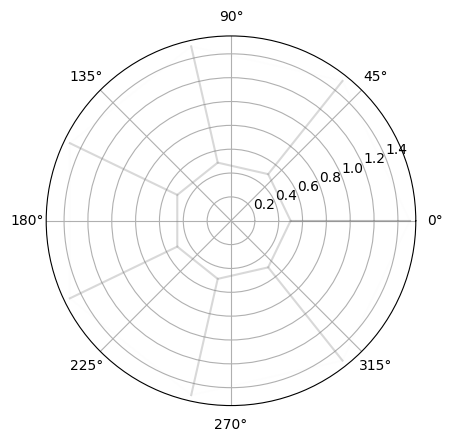

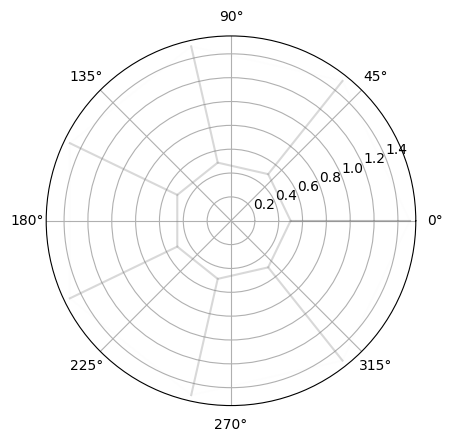

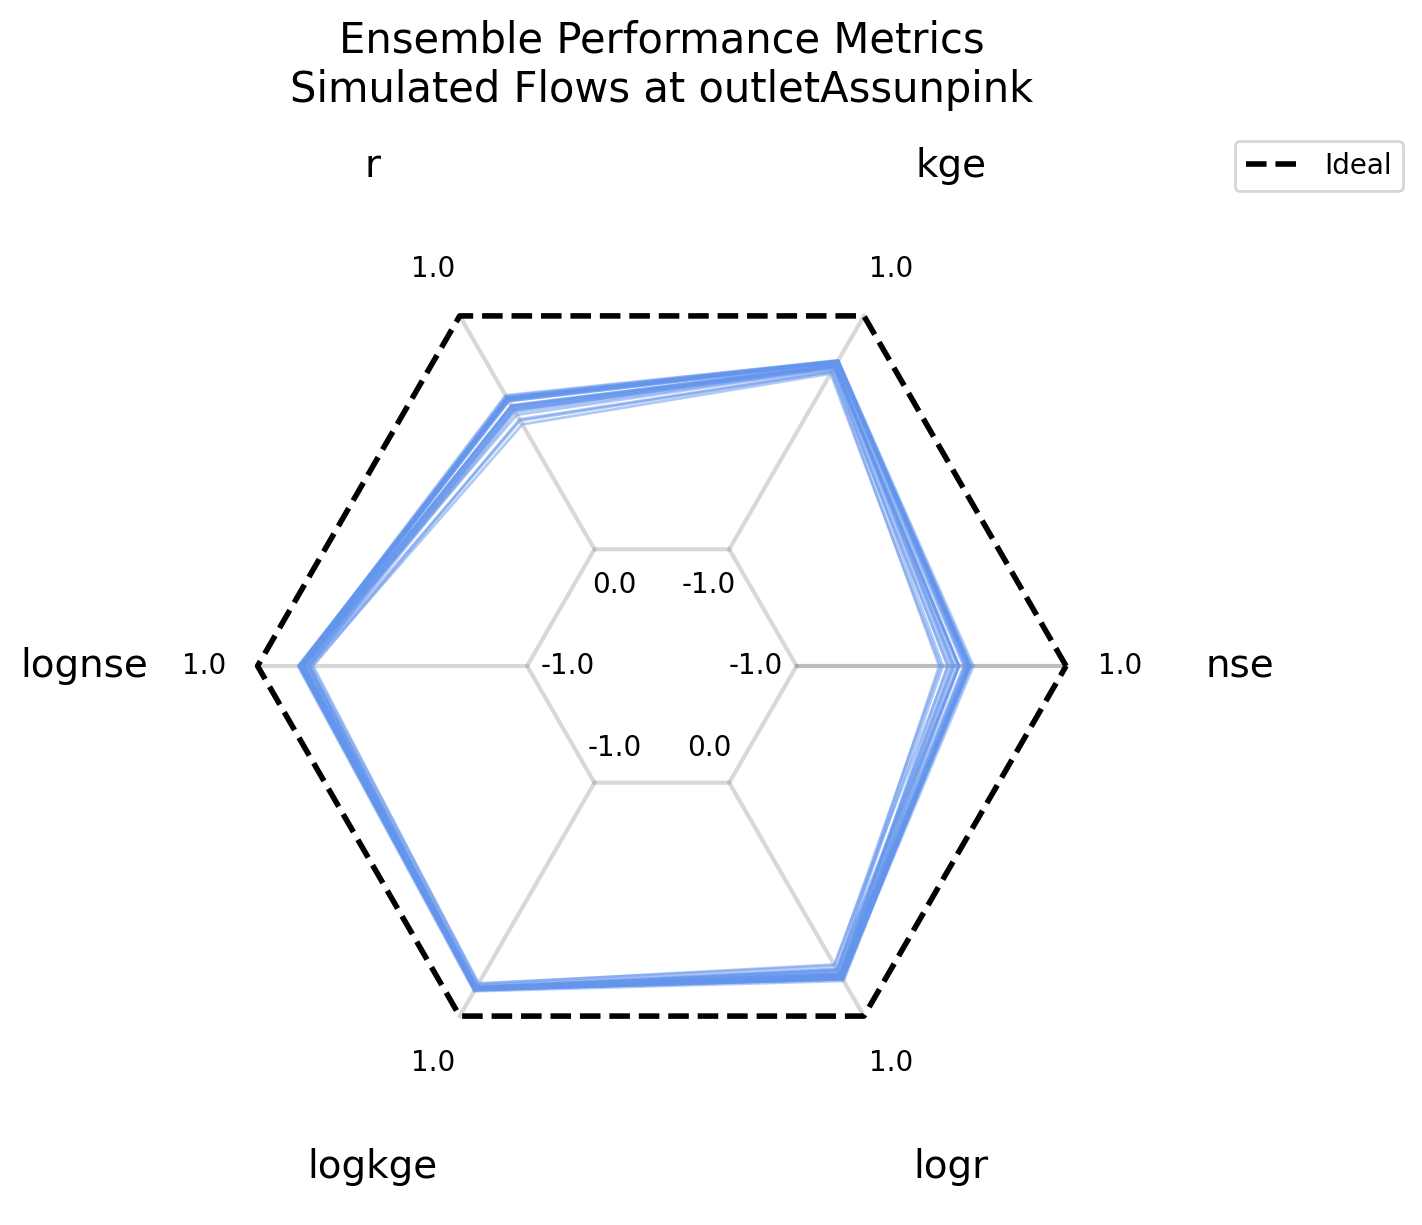

In [495]:
use_metrics = ['nse', 'kge', 'r', 'lognse', 'logkge', 'logr']
plot_models = ['pywr_obs_pub_nhmv10_NYCScaled_ensemble']

for plot_node in ['outletAssunpink']:

    multimodel_polar_plot(major_flows, models=plot_models, node=plot_node, 
                    metric_names=use_metrics, ideal_score=np.array([1,1,1,1,1,1]),
                    colordict=base_model_colors,
                    filename=f'polar_errors_{plot_node}_{plot_models}.png', sub_title=f'Simulated Flows at {plot_node}', metric_mins = [-1,-1,0,-1,-1,0], r_max = 1.5,
                    line_alpha=0.5,
                    figsize=(7,7),
                    scale_ideal=True,
                    plot_spokes=True,
                    save_fig=True)

In [453]:
base_model_colors['pywr_obs_pub_nhmv10_NYCScaled_ensemble'] = 'cornflowerblue'

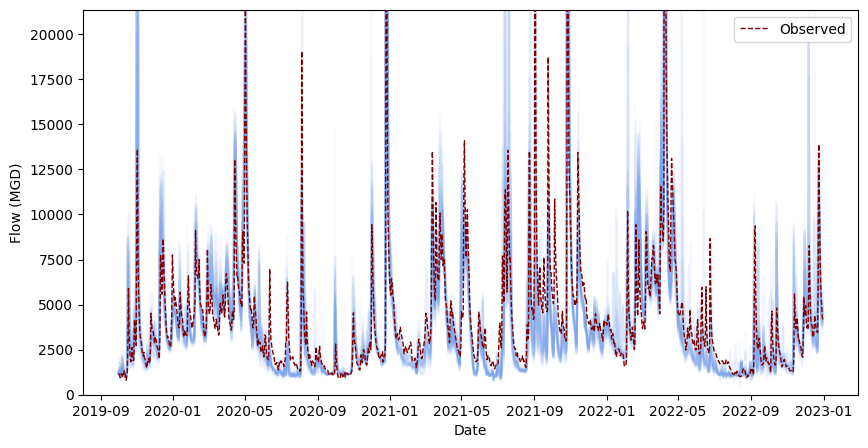

In [536]:
def rolling_mean(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'valid')

def plot_ensemble_timeseries(ensemble_results, observed_results, models, node, start_date, end_date,
                             color_dict = base_model_colors,
                             fill_range=True, show_median=True, log_scale=False):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Gether ensemble results
    ts = pd.date_range(start_date, end_date, freq='D')
    
    
    # Plot ensemble results
    for m in models:
        col = color_dict[m] if m in color_dict.keys() else 'gray'
        
        if 'ensemble' in m:
            all_ensemble_flows = np.zeros((len(ensemble_results[m]), len(ts)))
            for j, real in enumerate(ensemble_results[m].keys()):
                modeled = ensemble_results[m][real].loc[start_date:end_date, :]
                all_ensemble_flows[j, :] = modeled[node].values
                
                if not fill_range:
                    ax.plot(modeled.index, modeled[node], color = col, alpha = 0.05, 
                        zorder=0)
            if fill_range:
                lower = np.quantile(all_ensemble_flows, 0.05, axis=0)
                upper = np.quantile(all_ensemble_flows, 0.95, axis=0)
                lower = rolling_mean(lower, 3)
                upper= rolling_mean(upper, 3)
                ax.fill_between(modeled.index[2:], lower, upper,
                                color = col, alpha = 0.5, zorder=0)

        else:
            modeled = ensemble_results[m]['realization_0'].loc[start_date:end_date, :]
            ax.plot(modeled.index, modeled[node], color = col, alpha = 1, lw=1, label=m, zorder=1)
    
    # Plot observed results
    obs = observed_results.loc[start_date:end_date, :]
    ax.plot(obs.index, obs[node], 
            color = 'maroon', alpha = 1, lw=1, ls='dashed', 
            zorder=3,
            label='Observed')

    # Format plot
    ax.set_ylabel('Flow (MGD)') 
    ax.set_xlabel('Date')
    if log_scale:
        ax.set_yscale('log')
    else:
        ax.set_ylim(0, np.quantile(all_ensemble_flows, 0.99))

    plt.legend()
    plt.show()
    return

plot_ensemble_timeseries(ensemble_results=major_flows, 
                         observed_results=major_flows['obs'], 
                         models=['pywr_obs_pub_nhmv10_NYCScaled_ensemble'],
                         log_scale=False, fill_range=False,
                         node='delMontague', start_date='2019-10-01', end_date='2022-12-31')

In [518]:
major_flows['pywr_obs_pub_nhmv10_NYCScaled_ensemble']['realization_0']['01436000']

2017-10-01    109.254015
2017-10-02    109.390414
2017-10-03    107.634576
2017-10-04     96.493943
2017-10-05     92.348239
                 ...    
2022-12-27    121.631942
2022-12-28    112.109859
2022-12-29    104.504836
2022-12-30    109.101699
2022-12-31    152.152358
Name: 01436000, Length: 1918, dtype: float64

In [525]:
np.rolling(window=3, center=True, axis=0)

AttributeError: module 'numpy' has no attribute 'rolling'